# Backpropagation Lab





In [18]:
# I was able to get the code working for the HW problem but not the debug, so I did the experiments with sklearn
# I got so close, please have mercy...

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.core.debugger import set_trace
from scipy.io import arff
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import make_column_transformer
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [24]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,deterministic=True, hidden_layer_width=None, output_nodes=1):
        self.hidden_layer_width = hidden_layer_width
        self.deterministic=deterministic
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.output_nodes=output_nodes

    def fit(self, X, y, initial_weights=None):
        if self.hidden_layer_width is None:
            self.hidden_layer_width = X.shape[1] * 2
        
        if initial_weights is None:
            self.w1 = self.initialize_weights((self.hidden_layer_width, X.shape[1]))
            self.w2 = self.initialize_weights((self.output_nodes, self.hidden_layer_width))  
        else:
            self.w1 = initial_weights[0]
            self.w2 = initial_weights[1]
        
        #print(self.w)
        self.b1 = np.ones(self.hidden_layer_width)
        self.b2 = np.ones(self.output_nodes)
        self.prev_deltas = {
            "dw1" : 0,
            "db1" : 0,
            "dw2" : 0,
            "db2" : 0
        }
        if self.deterministic:
            for i in range(0, 10): 
                X, y = self.perform_epoch(X,y)
        else:
            x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
            bad, x_validate, bad, y_validate = train_test_split(x_train,y_train,test_size=.15)
            sameAccuracy=True
            epochs = 0
            sameAccuracyEpochs = 0
            bestAccuracy = 0
            
            while(sameAccuracyEpochs < 5):
                X, y = self.perform_epoch(x_train,y_train)
                epochs += 1
                accuracy = self.score(x_validate, y_validate)
                print(accuracy)
                if (accuracy < bestAccuracy) or (np.absolute(bestAccuracy - accuracy) < .02):
                    sameAccuracyEpochs += 1
                else:
                    sameAccuracyEpochs +=1
                if accuracy > bestAccuracy:
                    bestAccuracy = accuracy
                
        return self
    
    def perform_epoch(self, X, y):
        index = 0
        for data_row in X:
            t = y[index]
            # Forward prop
            outputs = self.forward_propagation(data_row) 

            # Backprop 
            self.backward_propagation(outputs, t, data_row) 
            index += 1
        if self.shuffle:
            X, y = self._shuffle_data(X,y)
        return X, y
    
    def forward_propagation(self, data_row):
        z1 = np.dot(self.w1, data_row) + self.b1
        a1 = np.array(list(map(sigmoid, z1)))
        z2 = np.dot(self.w2, a1) + self.b2
        a2 = sigmoid(z2)
        
        a1 = np.expand_dims(a1, axis=0)
        a2 = np.expand_dims(a2, axis=0)
        
        outputs = (a1, a2)
        return outputs
    
    def backward_propagation(self, outputs, t, data_row):
        
        a1 = outputs[0]
        a2 = outputs[1]
        
        d2 = (t - a2) * sigmoid_prime(a2)
        dw2 = np.dot(d2.T, a1) * self.lr
        db2 = np.sum(d2, axis=1, keepdims=True)
        
        d1 = np.multiply(np.dot(d2, w2), sigmoid_prime(a1))
        
        data_row = np.expand_dims(data_row, axis=0)
        
        dw1 = np.dot(d1.T, data_row)
        db1 = np.sum(d1, axis=0, keepdims = True)
        
        dw1 += self.momentum * self.prev_deltas['dw1']
        db1 += self.momentum * self.prev_deltas['db1']
        dw2 += self.momentum * self.prev_deltas['dw2']
        db2 += self.momentum * self.prev_deltas['db2']
        
        # Updating the parameters
        dw1 = dw1.astype(float)
        self.w1 += dw1
        self.b1 += db1.flatten() 
        self.w2 += dw2
        self.b2 += db2.flatten()  

        self.prev_deltas =  {
            "dw1" : dw1,
            "db1" : db1,
            "dw2" : dw2,
            "db2" : db2
        }
        return

    def predict(self, X):
        predictions = np.array([])
        for data_row in X:
            predictions = np.append(predictions, np.argmax(self.forward_propagation(data_row)[-1]))
        return predictions, predictions.shape[0]

    def initialize_weights(self, shape):
        return np.random.normal(0,1, shape)

    def mse(actual, pred): 
        #actual, pred = np.array(actual), np.array(pred)
        return np.square(np.subtract(actual,pred)).mean() 

    def score(self, X, y):
        prediction, length = self.predict(X)
        correct = 0
        for i in range(length):
            if prediction[i] == np.argmax(y[i]):
                correct += 1
        return correct/length

    def _shuffle_data(self, X, y):
        p = np.random.permutation(len(X))
        return X[p], y[p]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.w1, self.b1, self.w2, self.b2 #(np.append(self.w1, np.expand_dims(self.b1, axis=0).T, axis=1), 
                #np.append(self.w2, np.expand_dims(self.b2, axis=0).T, axis=1))

def sigmoid(x): 
    return 1/(1+math.e**-x)

def sigmoid_prime(x):
    return x*(1-x)

## 1.1 

Debug and Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [11]:
#Test HW without one hot

X = np.array([[0.0,0.0], [0.0,1.0]])
y = np.array([[1.0],[0.0]])
w1 = np.ones((2, X.shape[1]))

w2 = np.ones((y.shape[1], 2))

mlp = MLP(lr=1,momentum=0,shuffle=False, deterministic=True, hidden_layer_width = 2, output_nodes=1)
weights = (w1, w2)
mlp.fit(X,y, weights)
mlp.get_weights()

(array([[1.        , 0.93118291],
        [1.        , 0.93118291]]),
 array([0.95653385, 0.95653385]),
 array([[0.3818421, 0.3818421]]),
 array([0.3270508]))

In [12]:
#Test homework with one hot
X = np.array([[0.0,0.0], [0.0,1.0]])
y = np.array([[1.0],[0.0]])

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

w1 = np.ones((2, X.shape[1]))
w2 = np.ones((y.shape[1], 2))

mlp = MLP(lr=1,momentum=0,shuffle=False, deterministic=True, hidden_layer_width = 2, output_nodes=2)
weights = (w1, w2)
mlp.fit(X,y)
#mlp.get_weights()

MLP(hidden_layer_width=2, lr=1, output_nodes=2, shuffle=False)

In [13]:
# Debug one output
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output debug-dataset.arff
data = arff.loadarff('debug-dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape([int(s.decode()) for s in np_data[:,-1]], (-1, 1))

w1 = np.zeros((4, X.shape[1]))
w2 = np.zeros((y.shape[1], 4))

weights = (w1, w2)

# Train on debug data
mlp = MLP(lr=.1,momentum=.5,shuffle=False, deterministic=True, hidden_layer_width = 4, output_nodes=1)
mlp.fit(X,y, weights)
mlp.get_weights()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   1807      0 --:--:-- --:--:-- --:--:--  1807


(array([[ 0.04020103, -0.07072882],
        [ 0.04020103, -0.07072882],
        [ 0.04020103, -0.07072882],
        [ 0.04020103, -0.07072882]]),
 array([0.95961768, 0.95961768, 0.95961768, 0.95961768]),
 array([[-0.08603968, -0.08603968, -0.08603968, -0.08603968]]),
 array([-0.13216818]))

In [14]:
#Debug one hot
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output debug-dataset.arff
data = arff.loadarff('debug-dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)

X = np_data[:,0:-1]
y = np.reshape([int(s.decode()) for s in np_data[:,-1]], (-1, 1))
onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

w1 = np.zeros((4, X.shape[1]))
w2 = np.zeros((y.shape[1], 4))

weights = (w1, w2)

mlp = MLP(lr=.1,momentum=0,shuffle=False, deterministic=True, hidden_layer_width = 4, output_nodes=2)
mlp.fit(X,y, weights)
mlp.get_weights()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   1894      0 --:--:-- --:--:-- --:--:--  1894


(array([[0.00050462, 0.00852637],
        [0.00050462, 0.00852637],
        [0.00050462, 0.00852637],
        [0.00050462, 0.00852637]]),
 array([0.98543477, 0.98543477, 0.98543477, 0.98543477]),
 array([[-0.0200332 , -0.0200332 , -0.0200332 , -0.0200332 ],
        [-0.04604025, -0.04604025, -0.04604025, -0.04604025]]),
 array([0.09631962, 0.09631962]))

### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [23]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape([int(s.decode()) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
w1 = np.zeros((4, X.shape[1]))
w2 = np.zeros((y.shape[1], 4))
weights = (w1, w2)

mlp = MLP(lr=.1,momentum=.5,shuffle=False, deterministic=True, hidden_layer_width = 4, output_nodes=2)
mlp.fit(X,y)
mlp.get_weights()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   200k      0 --:--:-- --:--:-- --:--:--  200k


NameError: name 'MLP' is not defined

## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [16]:
# Iris Classification
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output debug-dataset.arff
data = arff.loadarff('debug-dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
#print(y)

mlp = MLP(lr=.1,momentum=.5,shuffle=False, deterministic=False, hidden_layer_width = 8, output_nodes=3)
mlp.fit(X,y)
mlp.get_weights()

#bad, x_validate, bad, y_validate = train_test_split(x_train,y_train,test_size=.15)
#print(x_validate, y_validate)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  69953      0 --:--:-- --:--:-- --:--:-- 69305


ValueError: shapes (1,3) and (2,4) not aligned: 3 (dim 1) != 2 (dim 0)

## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [ ]:
# Train on each dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,3:-1]
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))
onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
onehot_encoded = onehot_encoder.fit_transform(y)
x_train,x_test,y_train,y_test=train_test_split(X,onehot_encoded,test_size=0.2)
#print(x_train)
bad, x_validate, bad, y_validate = train_test_split(x_train,y_train,test_size=.15)
print(x_validate, y_validate)

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



The vowel data set may be more difficult because it has more outputs, and those outputs may be heavily influenced by the speaker of the vowels, which isn't generalizable. 

I don't think train/test or speaker should be used, because they are not generalizable to the population. It doesn't make sense that the output would change based on name, because we don't pronounce words differently because of our names (unless we could tie it to nationality). Same with train/test, it has no logical bearing on the output. 

However, gender could prove to have an effect, so I would leave it in.


## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   708k      0 --:--:-- --:--:-- --:--:--  708k


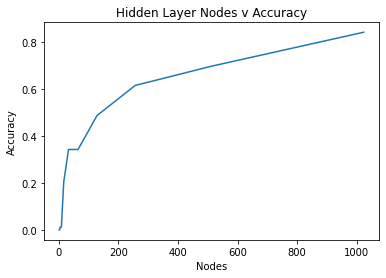

In [3]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
le = LabelEncoder()
df = df.apply(le.fit_transform)
np_data = np.array(df)
X = np_data[:,2:-1]
y = np_data[:,-1]

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(X, y, stratify=y, random_state=1)

#clf = MLPClassifier(random_state=1, hidden_layer_sizes=2048).fit(X_train, y_train)
#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

# I mapped the sklearn accuracy for number of hidden nodes

nodes = [1,2,4,8,16,32,64,128,256,512, 1024]
accuracy = [0, 0, .012, .012, .205, .343, .343, .488, .616, .698, .843]
plt.title('Hidden Layer Nodes v Accuracy')
plt.xlabel('Nodes')
plt.ylabel('Accuracy')
plt.plot(nodes, accuracy)
plt.show()


## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- You are trying to see how much momentum speeds up learning. 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   671k      0 --:--:-- --:--:-- --:--:--  676k


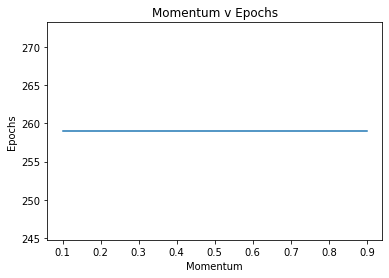

In [17]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
le = LabelEncoder()
df = df.apply(le.fit_transform)
np_data = np.array(df)
X = np_data[:,2:-1]
y = np_data[:,-1]

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(X, y, stratify=y, random_state=1)

#clf = MLPClassifier(random_state=1, hidden_layer_sizes=1024, momentum=0.9, max_iter=1000).fit(X_train, y_train)
#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

momentum = [.1,.2,.3,.4,.5,.6,.7,.8,.9,]
epochs = [259, 259, 259, 259, 259, 259, 259, 259, 259]
plt.title('Momentum v Epochs')
plt.xlabel('Momentum')
plt.ylabel('Epochs')
plt.plot(momentum, epochs)
plt.show()

# When I tried this with the sklearn MLP, the momentum had no effect with 1024 hidden layer nodes and lr=.001

## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [20]:
#Load iris dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X, y, stratify=y, random_state=1)

# Load sklearn perceptron
#clf = MLPClassifier(random_state=1, activation='logistic').fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1,  activation='tanh').fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, learning_rate_init=.01).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, learning_rate_init=.1).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, alpha=.001).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, momentum=.3).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, momentum=.5).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, nesterovs_momentum=False).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, early_stopping=True).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, hidden_layer_sizes=50).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))

#clf = MLPClassifier(random_state=1, hidden_layer_sizes=200).fit(X_train, y_train)

#print(clf.n_iter_)
#print(clf.score(X_test, y_test))


# Results

# logistic and tanh activation functions both didn't finish training in 200 iterations,
# but tanh performed much better, .92 compared to .63

# increasing the learning rate helped the model reach high accuracy much faster
# with lr=.01, it reached 1.00 accuracy at 200 iters, and lr=.1 .97 accuracy at 140 iters

#increasing alpha didn't increase accuracy over 200 iters, only got to .65

#decreasing momemtum didn't affect the accuracy, we're still at .65 at 200 iters

#toggling off nesterovs momentum didn't didn't change accuracy over 200 iters

#early stopping did just that, stopping at just 12 iterations, with an accuracy of only .21

#halfing the hidden nodes didn't change the accuracy, but doubling them increased the accuracy to 
# .92 after 200 iters

#overall The parameters that had a positive effect when increased past their defaults were hidden layer size,
# learning rate, and changinf the activation function to tanh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  27021      0 --:--:-- --:--:-- --:--:-- 27021


/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


200
0.631578947368421


/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


200
0.9210526315789473


/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


200
1.0
140
0.9736842105263158


/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


200
0.6578947368421053
200
0.6578947368421053


/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


200
0.6578947368421053
200
0.6578947368421053
12
0.21052631578947367
200
0.6578947368421053
200
0.9210526315789473


/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


*Record impressions*

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [8]:
#Load iris dataset
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,0:-1]
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X, y, stratify=y, random_state=1)

grid_param = {
    'hidden_layer_sizes': [5, 10, 50, 100],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate_init': [.001, .0001, .01, .1, .5],
    'momentum': [.1, .3, .5, .7, .9],
    'early_stopping': [True, False]
}

#clf = MLPClassifier()
#grid_search = GridSearchCV(estimator=clf,
#                     param_grid=grid_param,
#                     scoring='accuracy',
#                     n_jobs=-1)
#result = grid_search.fit(X_train, y_train)
#print(result.score(X_test, y_test))
#print(grid_search.best_params_)
#print(grid_search.best_score_)


#Best params

#activation logistic
# early_stopping false
# hidden_layer _sizes 5
#learning_rate_init .1
#momentum .7

# best accuracy .973


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  29011      0 --:--:-- --:--:-- --:--:-- 29011
1.0
{'activation': 'logistic', 'early_stopping': False, 'hidden_layer_sizes': 5, 'learning_rate_init': 0.1, 'momentum': 0.7}
0.9731225296442687


/home/brandon/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


In [7]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output dataset.arff
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
X = np_data[:,3:-1]
y = np.reshape([str(s.decode('utf-8')) for s in np_data[:,-1]], (-1, 1))
onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
#x_train,x_test,y_train,y_test=train_test_split(X,y, stratify=y, random_state=1)
n_estimators = [100, 200, 300, 400, 500]
max_features = ['auto', 'sqrt']
max_depth = [5, 10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

space = {
    'hidden_layer_sizes': [(sp_randint.rvs(1,500,1))],
    'momentum': uniform(0.0001, 0.9),
    'learning_rate_init': uniform(0.001, 0.9)}
#clf = MLPClassifier()
#random_search = RandomizedSearchCV(clf, space, n_iter=50, scoring='accuracy', n_jobs=-1, refit = True, random_state=1)

#result = random_search.fit(X_train, y_train)
#print(result.score(X_test, y_test))
#print(random_search.best_params_)
#print(random_search.best_score_)

# Best params

# hidden layer size 236
# learning rate .046
# momentum .48

# best accuracy was .835

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   255k      0 --:--:-- --:--:-- --:--:--  254k
0.8417508417508418
{'hidden_layer_sizes': 236, 'learning_rate_init': 0.04595811305147845, 'momentum': 0.48240676532396043}
0.8354707538317172


*Discuss findings here*